In [ ]:
from PIL import Image
import torch
import os
import numpy as np
from modeling.BaseModel import BaseModel
from modeling import build_model
from utilities.distributed import init_distributed
from utilities.arguments import load_opt_from_config_files
from utilities.constants import BIOMED_CLASSES

from inference_utils.inference import interactive_infer_image_all
from inference_utils.output_processing import check_mask_stats

os.environ['CUDA_VISIBLE_DEVICES'] = '1'  # Set the GPU device to use

In [ ]:
import huggingface_hub

# HF_TOKEN = 'YOUR_HUGGINGFACE_TOKEN'
HF_TOKEN = ''

huggingface_hub.login(HF_TOKEN)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /home/ji/.cache/huggingface/token
Login successful


### Model Setup

In [ ]:
# Build model config
opt = load_opt_from_config_files(["configs/biomedparse_inference.yaml"])
opt = init_distributed(opt)

# Load model from pretrained weights
# pretrained_pth = ':microsoft/BiomedParse'
pretrained_pth = '/media/Datacenter_storage/Ji/BiomedParse/pretrained/biomedparse_v1.pt'
# pretrained_pth = '/media/Datacenter_storage/Ji/BiomedParse/output/biomed_seg_lang_v1.yaml_conf~/run_9/00094640/default/model_state_dict.pt'

model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval().cuda()
with torch.no_grad():
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(BIOMED_CLASSES + ["background"], is_eval=True)

/media/Datacenter_storage/Ji/miniconda3/envs/biomedparse/lib/python3.9/site-packages/transformers/modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return

### Utility Functions

In [14]:
from detectron2.data.datasets.builtin_meta import COCO_CATEGORIES

colors_list = [(np.array(color['color'])).tolist() for color in COCO_CATEGORIES]
color_codes = [f'#{color[0]:02x}{color[1]:02x}{color[2]:02x}' for color in colors_list]

def plot_segmentation_masks(original_image, segmentation_masks, texts):
    ''' Plot a list of segmentation masks on the same image.
    '''
    original_image = original_image[:, :, :3]
    mask_temp = original_image.copy()
    for i, mask in enumerate(segmentation_masks):
        mask_temp[mask > 0.5] = colors_list[i]
    
    # merge the original image with the masks
    image_to_show = (original_image * 0.5 + mask_temp * 0.5) / 255.0
    
        
    # plot the final image
    plt.imshow(image_to_show)
    plt.axis('off')
    
    # add the legend with marker size 20
    for i, text in enumerate(texts):
        plt.plot([], [], '.', color=color_codes[i], markersize=20, label=text)
    # legend to the right outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()

In [15]:
!pip install pydicom nibabel SimpleITK

import json
import matplotlib.pyplot as plt

from inference_utils.processing_utils import read_rgb


def inference_recognition(file_path, image_type, p_value_threshold=None):
    image = read_rgb(file_path)
    
    predictions = interactive_infer_image_all(model, Image.fromarray(image), image_type, p_value_threshold)
    targets = list(predictions.keys())
    pred_mask = [predictions[t] for t in targets]
    # Plot feature over image
    plot_segmentation_masks(image, pred_mask, targets)
    
    return image, pred_mask


### Pathology Example

In [8]:
# image_path = 'examples/Part_1_516_pathology_breast.png'
# image_type = 'Pathology'

# image, pred_mask = inference_recognition(image_path, image_type)

### X-Ray Example

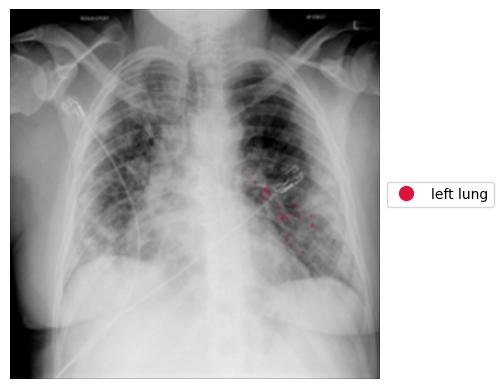

In [16]:
image_path = 'examples/covid_1585.png'
image_type = 'X-Ray-Chest'

image, pred_mask = inference_recognition(image_path, image_type)

### Fundus Example

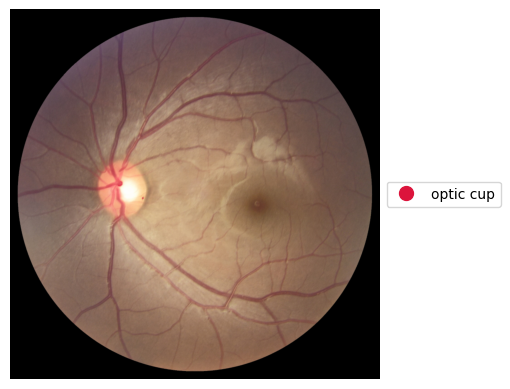

In [ ]:
image_path = 'examples/T0011.jpg'
image_type = 'Fundus'

image, pred_mask = inference_recognition(image_path, image_type)

### CT Example

In [ ]:
image_path = 'biomedparse_datasets/BiomedParseData-Demo/demo/01_CT_lung.png'
image_type = 'CT-Chest'

image, pred_mask = inference_recognition(image_path, image_type)

IndexError: list index out of range

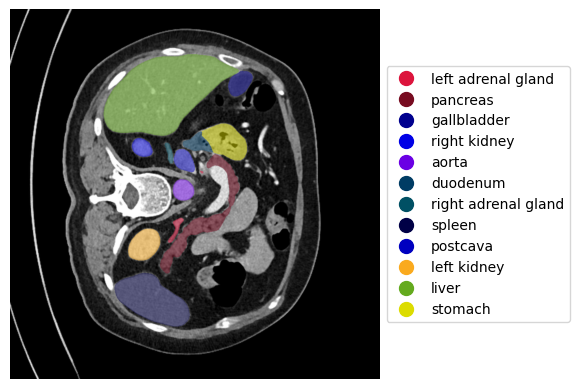

In [ ]:
image_path = 'biomedparse_datasets/BiomedParseData-Demo/demo/06_CT_abdomen.png'
image_type = 'CT-Abdomen'

image, pred_mask = inference_recognition(image_path, image_type)

### MRI Example

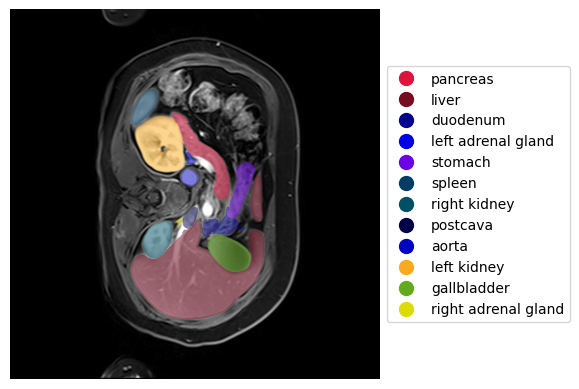

In [ ]:
image_path = 'biomedparse_datasets/BiomedParseData-Demo/demo/13_MRI_abdomen.png'
image_type = 'MRI-Abdomen'

image, pred_mask = inference_recognition(image_path, image_type)

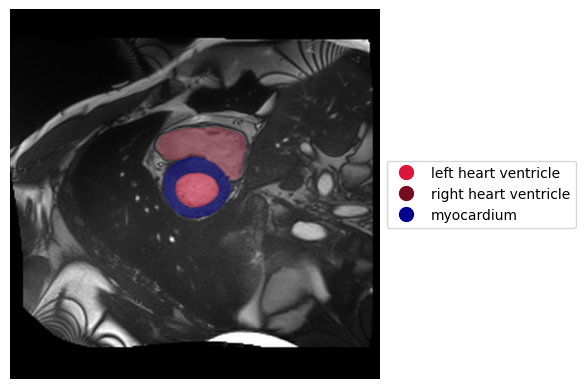

In [ ]:
image_path = 'biomedparse_datasets/BiomedParseData-Demo/demo/08_MRI_heart.png'
image_type = 'MRI-Cardiac'

image, pred_mask = inference_recognition(image_path, image_type)

In [ ]:
image_path = '/media/Datacenter_storage/Ji/BiomedParse/examples/sub-108_slice_016.png'
image_type = 'Brain_MRI'

image, pred_mask = inference_recognition(image_path, image_type)

NameError: name 'inference_recognition' is not defined

In [ ]:
# image_path = '/media/Datacenter_storage/Ji/BiomedParse/examples/sub-232_slice_109.png'
image_path = "/media/Datacenter_storage/Ji/BiomedParse/biomedparse_datasets/valdo_biomedparse/train/sub-104-slice-023_MRI_Brain.png"
image_type = 'MRI-FLAIR-Brain'

image, pred_mask = inference_recognition(image_path, image_type)

ValueError: Currently support modality types: ['CT-Abdomen', 'CT-Chest', 'CT-Liver', 'MRI-Abdomen', 'MRI-Cardiac', 'MRI-FLAIR-Brain', 'MRI-T1-Gd-Brain', 'Pathology', 'X-Ray-Chest', 'Ultrasound-Cardiac', 'Endoscopy', 'Fundus', 'Dermoscopy', 'OCT', 'MRI']